In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import graph_tool.all as gt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import sklearn.metrics as metrics
from umap import UMAP

from functions import *


# Style
sns.set_theme(context='paper', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Parameters

In [3]:
col = 'SCZ'
batch_size = 32
seed = 42

## Script
# cols = [
#     'PD', 'PD_uncertain_plus_encephalitic', 'DLBD', 'FTD',
#     'ALS', 'Others_Neurodegenerative', 'MS', 'PSP', 'Epilepsy', 'Seizures',
#     'Tumor', 'Migraine_headaches', 'Head_Injury', 'Vascular', 'Others_Neurological',
#     'SCZ', 'MDD', 'BD_unspecific', 'BD_I', 'BD_II', 'PTSD', 'ADHD',
#     'OCD', 'Tardive_Dyskinesia_Neuroleptic_induced', 'Schizoaffective_bipolar',
#     'Schizoaffective_depressive', 'Anorexia', 'Bulimia', 'Anxiety',
#     'Binge_Purge', 'Eating_disorder', 'Others_Neuropsychiatric',
#     'Diabetes_mellitus_unspecified', 'TD_I', 'TD_II',
# ]  # Columns to analyze (HBCC)
# for col in cols:
#     print()
#     print(col)

# Data

In [4]:
# Get data
meta = get_meta()
graph_embeddings = load_graph_embeddings()

# Format embeddings
labels = []
embeddings = []
for k, v in graph_embeddings.items():
    labels.append(k)
    embeddings.append(v)
embeddings = np.stack(embeddings, axis=0)

# Convert to torch data
embeds = torch.tensor(embeddings)
classes = [meta.loc[meta['SubID']==sid][col].item() for sid in labels]
classes = torch.tensor(classes).long()

# Skip if any other than two classes
unq, cnt = classes.unique(return_counts=True)
print(f'Unique values {list(unq.numpy())} with counts {list(cnt.numpy())}')
if unq.shape[0] != 2 or cnt.min() < 5:  # 5 is arbitrary here and based on .8
    print(f'Insufficient data, skipping.')
    ## Script
    # continue

Unique values [0, 1] with counts [250, 50]


# Train Model

In [5]:
## Model initialization
# Initialize
np.random.seed(seed)
torch.manual_seed(seed)

# Create model
class Model(torch.nn.Module):
    def __init__(self, input_dim=128, output_dim=2):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(.8),
            
            nn.Linear(input_dim // 2, output_dim),
            nn.BatchNorm1d(output_dim),
            # nn.Softmax(dim=-1),
        )
        
    def forward(self, X):
        return self.net(X)
    
model = Model(
    input_dim=embeds.shape[1],
    output_dim=classes.unique().shape[0],
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=1)
criterion = nn.CrossEntropyLoss()

In [6]:
## Training loop
# Split to train and test idx
train_idx = val_idx = 0
while np.unique(classes[train_idx]).shape[0] < 2 or np.unique(classes[val_idx]).shape[0] < 2:
    # Keep splitting until each of train and val have at least one sample
    train_idx = np.random.choice(embeds.shape[0], int(.8 * embeds.shape[0]), replace=False)
    val_idx = np.array(list(set(range(embeds.shape[0])) - set(train_idx)))

# Train
model.train()
for epoch in range(1001):
    for _ in range(len(train_idx) // batch_size):
        # Calculate loss
        batch_idx = np.random.choice(train_idx, batch_size, replace=False)
        logits = model(embeds[batch_idx])
        loss = criterion(logits, classes[batch_idx])
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    
    if epoch % 100 == 0:
        # Calculate val loss
        model.eval()
        logits = model(embeds[val_idx])
        val_loss = criterion(logits, classes[val_idx])
        model.train()

        # CLI
        print(f'Epoch: {epoch:03} - Loss: {loss.item():.3f} - Val Loss: {val_loss.item():.3f}')
model.eval();

Epoch: 000 - Loss: 1.059 - Val Loss: 0.869
Epoch: 100 - Loss: 0.722 - Val Loss: 0.715
Epoch: 200 - Loss: 0.587 - Val Loss: 0.533
Epoch: 300 - Loss: 0.577 - Val Loss: 0.609
Epoch: 400 - Loss: 0.525 - Val Loss: 0.542
Epoch: 500 - Loss: 0.505 - Val Loss: 0.520
Epoch: 600 - Loss: 0.562 - Val Loss: 0.564
Epoch: 700 - Loss: 0.393 - Val Loss: 0.487
Epoch: 800 - Loss: 0.382 - Val Loss: 0.600
Epoch: 900 - Loss: 0.390 - Val Loss: 0.533
Epoch: 1000 - Loss: 0.372 - Val Loss: 0.864


In [7]:
## Evaluation
# Calculate evaluation metrics
logits = model(embeds).detach()
preds = logits.argmax(dim=-1)
y_true = classes
for name, metric, y_pred in zip(
    ['BACC', 'AUROC', 'AUPRC'],
    [metrics.balanced_accuracy_score, metrics.roc_auc_score, metrics.average_precision_score],
    [preds, F.softmax(logits, dim=-1)[:, 1], preds]
):
    train_metric = metric(y_true[train_idx], y_pred[train_idx])
    val_metric = metric(y_true[val_idx], y_pred[val_idx])
    print(f'{name} (train={train_metric:.3f}, val={val_metric:.3f})')

BACC (train=0.669, val=0.676)
AUROC (train=0.838, val=0.608)
AUPRC (train=0.239, val=0.214)


## Plot

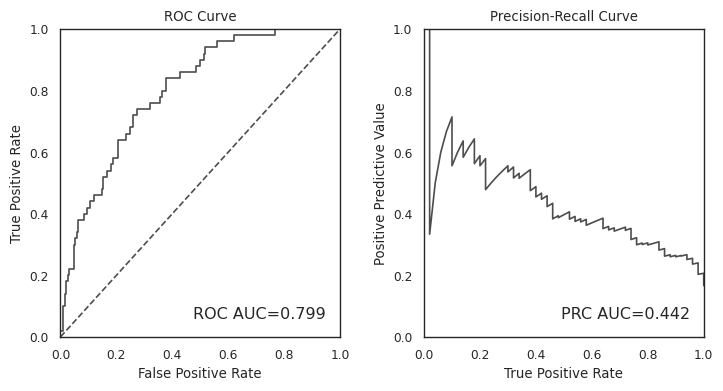

In [8]:
# Create figure
num_subplots = 2; wspace = .3; infigsize = 4
fig, axs = plt.subplots(1, num_subplots, figsize=(infigsize*num_subplots+wspace*(num_subplots-1), infigsize))
fig.subplots_adjust(wspace=wspace)

# UMAP
# ax = axs[0]
# umap = UMAP(
#     n_components=2,
#     n_neighbors=60,  # 15
#     min_dist=.5,  # .1
#     metric='euclidean',
#     random_state=42,
# ).fit_transform(embeddings)
# # Get colors
# color_index = np.array([str(v) for v in pd.unique(meta[col])])
# color = []
# for sid in labels:
#     val = str(meta.loc[meta['SubID']==sid][col].item())
#     color.append(val)
# color = np.array(color)
# # Plot
# for c in np.unique(color):
#     if float(c) == 1: label = col
#     elif float(c) == 0: label = 'Control'
#     else: label = 'NA'
#     ax.scatter(*umap[color==c].T, label=label)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xlabel('UMAP-1')
# ax.set_ylabel('UMAP-2')
# # Legend
# legend_handles, legend_labels = ax.get_legend_handles_labels()
# ax.legend(legend_handles[::-1], legend_labels[::-1])

# Compute logits
logits = model(embeds).detach()
preds = logits.argmax(dim=-1)
y_true = classes
y_pred = F.softmax(logits, dim=-1)[:, 1]

# Compute metrics
fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.roc_auc_score(y_true, y_pred)
precision, recall, prc_thresholds = metrics.precision_recall_curve(y_true, y_pred)
prc_auc = metrics.average_precision_score(y_true, y_pred)

# ROC Curve
ax = axs[0]
ax.plot(fpr, tpr, color='.3')
ax.plot([0, 1], [0, 1], color='.3', linestyle='--')
ax.text(.95, .05, f'ROC AUC={roc_auc:.3f}', ha='right', va='bottom', fontsize='large')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

# PRC
ax = axs[1]
ax.plot(recall, precision, color='.3')
ax.text(.95, .05, f'PRC AUC={prc_auc:.3f}', ha='right', va='bottom', fontsize='large')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('True Positive Rate')
ax.set_ylabel('Positive Predictive Value')
ax.set_title('Precision-Recall Curve')

# Save
fig.savefig(f'../plots/HBCC_performance_{col}.pdf', format='pdf', transparent=True, bbox_inches='tight')

## Results

In [9]:
# PD
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# PD_uncertain_plus_encephalitic
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# DLBD
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# FTD
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# ALS
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# Others_Neurodegenerative
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# MS
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# PSP
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# Epilepsy
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# Seizures
# Unique values [0, 1] with counts [288, 12]
# Epoch: 000 - Loss: 0.945 - Val Loss: 0.908
# Epoch: 100 - Loss: 0.676 - Val Loss: 0.613
# Epoch: 200 - Loss: 0.573 - Val Loss: 0.544
# Epoch: 300 - Loss: 0.532 - Val Loss: 0.525
# Epoch: 400 - Loss: 0.486 - Val Loss: 0.525
# Epoch: 500 - Loss: 0.422 - Val Loss: 0.426
# Epoch: 600 - Loss: 0.406 - Val Loss: 0.393
# Epoch: 700 - Loss: 0.359 - Val Loss: 0.385
# Epoch: 800 - Loss: 0.373 - Val Loss: 0.342
# Epoch: 900 - Loss: 0.290 - Val Loss: 0.266
# Epoch: 1000 - Loss: 0.311 - Val Loss: 0.301
# BACC (train=0.500, val=0.500)
# AUROC (train=0.899, val=0.305)
# AUPRC (train=0.046, val=0.017)

# Tumor
# Unique values [0, 1] with counts [299, 1]
# Insufficient data, skipping.

# Migraine_headaches
# Unique values [0, 1] with counts [289, 11]
# Epoch: 000 - Loss: 0.788 - Val Loss: 0.890
# Epoch: 100 - Loss: 0.670 - Val Loss: 0.636
# Epoch: 200 - Loss: 0.578 - Val Loss: 0.567
# Epoch: 300 - Loss: 0.522 - Val Loss: 0.562
# Epoch: 400 - Loss: 0.472 - Val Loss: 0.469
# Epoch: 500 - Loss: 0.443 - Val Loss: 0.482
# Epoch: 600 - Loss: 0.396 - Val Loss: 0.494
# Epoch: 700 - Loss: 0.395 - Val Loss: 0.473
# Epoch: 800 - Loss: 0.415 - Val Loss: 0.411
# Epoch: 900 - Loss: 0.298 - Val Loss: 0.273
# Epoch: 1000 - Loss: 0.322 - Val Loss: 0.251
# BACC (train=0.500, val=0.500)
# AUROC (train=0.930, val=0.661)
# AUPRC (train=0.042, val=0.017)

# Head_Injury
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# Vascular
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# Others_Neurological
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# SCZ
# Unique values [0, 1] with counts [250, 50]
# Epoch: 000 - Loss: 1.059 - Val Loss: 0.869
# Epoch: 100 - Loss: 0.722 - Val Loss: 0.715
# Epoch: 200 - Loss: 0.587 - Val Loss: 0.533
# Epoch: 300 - Loss: 0.577 - Val Loss: 0.609
# Epoch: 400 - Loss: 0.525 - Val Loss: 0.542
# Epoch: 500 - Loss: 0.505 - Val Loss: 0.520
# Epoch: 600 - Loss: 0.562 - Val Loss: 0.564
# Epoch: 700 - Loss: 0.393 - Val Loss: 0.487
# Epoch: 800 - Loss: 0.382 - Val Loss: 0.600
# Epoch: 900 - Loss: 0.390 - Val Loss: 0.533
# Epoch: 1000 - Loss: 0.372 - Val Loss: 0.864
# BACC (train=0.669, val=0.676)
# AUROC (train=0.838, val=0.608)
# AUPRC (train=0.239, val=0.214)

# MDD
# Unique values [0, 1] with counts [299, 1]
# Insufficient data, skipping.

# BD_unspecific
# Unique values [0, 1] with counts [294, 6]
# Epoch: 000 - Loss: 0.908 - Val Loss: 0.898
# Epoch: 100 - Loss: 0.662 - Val Loss: 0.652
# Epoch: 200 - Loss: 0.576 - Val Loss: 0.600
# Epoch: 300 - Loss: 0.515 - Val Loss: 0.551
# Epoch: 400 - Loss: 0.467 - Val Loss: 0.492
# Epoch: 500 - Loss: 0.420 - Val Loss: 0.476
# Epoch: 600 - Loss: 0.379 - Val Loss: 0.422
# Epoch: 700 - Loss: 0.364 - Val Loss: 0.370
# Epoch: 800 - Loss: 0.329 - Val Loss: 0.349
# Epoch: 900 - Loss: 0.280 - Val Loss: 0.338
# Epoch: 1000 - Loss: 0.283 - Val Loss: 0.296
# BACC (train=0.500, val=0.500)
# AUROC (train=0.897, val=0.424)
# AUPRC (train=0.021, val=0.017)

# BD_I
# Unique values [0, 1] with counts [245, 55]
# Epoch: 000 - Loss: 0.811 - Val Loss: 0.854
# Epoch: 100 - Loss: 0.705 - Val Loss: 0.651
# Epoch: 200 - Loss: 0.623 - Val Loss: 0.612
# Epoch: 300 - Loss: 0.584 - Val Loss: 0.631
# Epoch: 400 - Loss: 0.532 - Val Loss: 0.590
# Epoch: 500 - Loss: 0.516 - Val Loss: 0.610
# Epoch: 600 - Loss: 0.496 - Val Loss: 0.530
# Epoch: 700 - Loss: 0.568 - Val Loss: 0.547
# Epoch: 800 - Loss: 0.447 - Val Loss: 0.586
# Epoch: 900 - Loss: 0.447 - Val Loss: 0.953
# Epoch: 1000 - Loss: 0.506 - Val Loss: 0.499
# BACC (train=0.601, val=0.500)
# AUROC (train=0.788, val=0.512)
# AUPRC (train=0.331, val=0.133)

# BD_II
# Unique values [0, 1] with counts [293, 7]
# Epoch: 000 - Loss: 1.002 - Val Loss: 0.898
# Epoch: 100 - Loss: 0.666 - Val Loss: 0.660
# Epoch: 200 - Loss: 0.575 - Val Loss: 0.552
# Epoch: 300 - Loss: 0.529 - Val Loss: 0.510
# Epoch: 400 - Loss: 0.485 - Val Loss: 0.491
# Epoch: 500 - Loss: 0.438 - Val Loss: 0.441
# Epoch: 600 - Loss: 0.380 - Val Loss: 0.390
# Epoch: 700 - Loss: 0.371 - Val Loss: 0.382
# Epoch: 800 - Loss: 0.309 - Val Loss: 0.340
# Epoch: 900 - Loss: 0.337 - Val Loss: 0.318
# Epoch: 1000 - Loss: 0.257 - Val Loss: 0.325
# BACC (train=0.500, val=0.500)
# AUROC (train=0.932, val=0.525)
# AUPRC (train=0.025, val=0.017)

# PTSD
# Unique values [0, 1] with counts [299, 1]
# Insufficient data, skipping.

# ADHD
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# OCD
# Unique values [0, 1] with counts [294, 6]
# Epoch: 000 - Loss: 0.909 - Val Loss: 0.895
# Epoch: 100 - Loss: 0.672 - Val Loss: 0.639
# Epoch: 200 - Loss: 0.573 - Val Loss: 0.566
# Epoch: 300 - Loss: 0.519 - Val Loss: 0.521
# Epoch: 400 - Loss: 0.467 - Val Loss: 0.465
# Epoch: 500 - Loss: 0.420 - Val Loss: 0.445
# Epoch: 600 - Loss: 0.403 - Val Loss: 0.453
# Epoch: 700 - Loss: 0.367 - Val Loss: 0.380
# Epoch: 800 - Loss: 0.310 - Val Loss: 0.320
# Epoch: 900 - Loss: 0.281 - Val Loss: 0.311
# Epoch: 1000 - Loss: 0.252 - Val Loss: 0.322
# BACC (train=0.500, val=0.500)
# AUROC (train=0.999, val=0.780)
# AUPRC (train=0.021, val=0.017)

# Tardive_Dyskinesia_Neuroleptic_induced
# Unique values [0, 1] with counts [286, 14]
# Epoch: 000 - Loss: 0.914 - Val Loss: 0.902
# Epoch: 100 - Loss: 0.686 - Val Loss: 0.643
# Epoch: 200 - Loss: 0.575 - Val Loss: 0.565
# Epoch: 300 - Loss: 0.514 - Val Loss: 0.590
# Epoch: 400 - Loss: 0.481 - Val Loss: 0.538
# Epoch: 500 - Loss: 0.432 - Val Loss: 0.560
# Epoch: 600 - Loss: 0.411 - Val Loss: 0.481
# Epoch: 700 - Loss: 0.363 - Val Loss: 0.441
# Epoch: 800 - Loss: 0.313 - Val Loss: 0.440
# Epoch: 900 - Loss: 0.336 - Val Loss: 0.426
# Epoch: 1000 - Loss: 0.296 - Val Loss: 0.400
# BACC (train=0.500, val=0.491)
# AUROC (train=0.948, val=0.522)
# AUPRC (train=0.042, val=0.067)

# Schizoaffective_bipolar
# Unique values [0, 1] with counts [296, 4]
# Insufficient data, skipping.

# Schizoaffective_depressive
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# Anorexia
# Unique values [0, 1] with counts [296, 4]
# Insufficient data, skipping.

# Bulimia
# Unique values [0, 1] with counts [297, 3]
# Insufficient data, skipping.

# Anxiety
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# Binge_Purge
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# Eating_disorder
# Unique values [0, 1] with counts [298, 2]
# Insufficient data, skipping.

# Others_Neuropsychiatric
# Unique values [0] with counts [300]
# Insufficient data, skipping.

# Diabetes_mellitus_unspecified
# Unique values [0, 1] with counts [299, 1]
# Insufficient data, skipping.

# TD_I
# Unique values [0, 1] with counts [284, 16]
# Epoch: 000 - Loss: 0.908 - Val Loss: 0.895
# Epoch: 100 - Loss: 0.693 - Val Loss: 0.664
# Epoch: 200 - Loss: 0.575 - Val Loss: 0.576
# Epoch: 300 - Loss: 0.544 - Val Loss: 0.538
# Epoch: 400 - Loss: 0.475 - Val Loss: 0.498
# Epoch: 500 - Loss: 0.496 - Val Loss: 0.496
# Epoch: 600 - Loss: 0.421 - Val Loss: 0.443
# Epoch: 700 - Loss: 0.346 - Val Loss: 0.443
# Epoch: 800 - Loss: 0.377 - Val Loss: 0.445
# Epoch: 900 - Loss: 0.355 - Val Loss: 0.343
# Epoch: 1000 - Loss: 0.305 - Val Loss: 0.352
# BACC (train=0.500, val=0.500)
# AUROC (train=0.956, val=0.222)
# AUPRC (train=0.054, val=0.050)

# TD_II
# Unique values [0, 1] with counts [289, 11]
# Epoch: 000 - Loss: 0.821 - Val Loss: 0.887
# Epoch: 100 - Loss: 0.680 - Val Loss: 0.662
# Epoch: 200 - Loss: 0.582 - Val Loss: 0.531
# Epoch: 300 - Loss: 0.520 - Val Loss: 0.558
# Epoch: 400 - Loss: 0.470 - Val Loss: 0.497
# Epoch: 500 - Loss: 0.450 - Val Loss: 0.458
# Epoch: 600 - Loss: 0.403 - Val Loss: 0.430
# Epoch: 700 - Loss: 0.343 - Val Loss: 0.402
# Epoch: 800 - Loss: 0.314 - Val Loss: 0.417
# Epoch: 900 - Loss: 0.289 - Val Loss: 0.368
# Epoch: 1000 - Loss: 0.319 - Val Loss: 0.401
# BACC (train=0.625, val=0.500)
# AUROC (train=0.895, val=0.754)
# AUPRC (train=0.275, val=0.050)